453
log.file	state/execs/453.exec/log
Simulator.reqParams	grammar=1&cite=1&learn=1&logging=0
Simulator.logFiles	./shrdlurn/queries/freebuildbig-0206.context.json
total:21161	 induced:13618(0.6435), core:7460(0.3525), none:83(0.0039),
total:0.9340/0.9943, induced:0.5856/0.6418, core:0.3484/0.3525
avg(stats.size): 7.862719
avg(percent of status Induced): 64.354237
avg(percent of status Core): 35.253532
avg(percent of status Nothing): 12.710310
avg(percent of status Induced): 60.223799
avg(percent of status Core): 27.065891


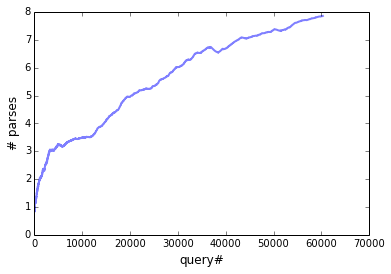

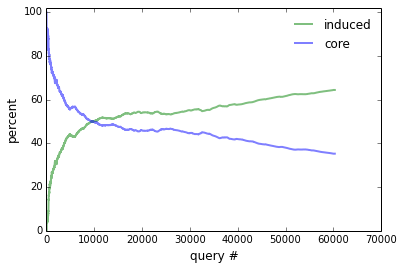

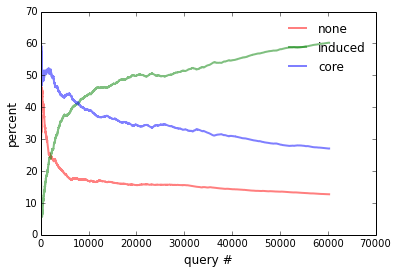

In [3]:
import csv
import numpy as np
import pandas as pd  
import matplotlib
import matplotlib.pyplot as plt
import json
import os
import subprocess
from collections import OrderedDict
%matplotlib inline  

with open('../state/lastExec', 'rb') as lastExec:
    lastExecInd = lastExec.readline().strip()
print lastExecInd
     
rows = []; 
execInd = lastExecInd;
execPath = '../state/execs/%s.exec/' % execInd
#print 'analyzing: ' + execPath
def printOptions():
    with open(os.path.join(execPath,'options.map')) as optionsfile:
        opts = filter(lambda l: 'file' in l or 'logFiles' in l  or 'reqParams' in l, optionsfile.readlines());
        for opt in opts: print opt.strip()
    # egrep 'file|Simulator'
printOptions()

with open('../state/execs/%s.exec/plotInfo.json' % execInd, 'rb') as jsonfile:
    json_lines = jsonfile.readlines()
    
rows = [json.loads(l) for l in json_lines]
# accepts = [[r['queryCount'], 1 if r['stats.rank']>=0 else 0] for r in rows if r['stats.type'] == 'accept'];


def print_stats():
    filtered_rows = [r for r in rows if r['stats.type'] == 'accept']
    induced_rows = [r for r in rows if r['stats.type'] == 'accept' and r['stats.status']=='Induced']
    core_rows = [r for r in rows if r['stats.type'] == 'accept' and r['stats.status']=='Core']
    none_rows = [r for r in rows if r['stats.type'] == 'accept' and r['stats.status']=='Nothing']

    stats =  {\
           'accepted': len(filtered_rows), \
           'induced': len(induced_rows), \
           'inducedp':len(induced_rows)/float(len(filtered_rows)),\
           'core': len(core_rows), \
           'corep':len(core_rows)/float(len(filtered_rows)),\
           'none': len(none_rows), \
           'nonep':len(none_rows)/float(len(filtered_rows))\
           }
    print 'total:{accepted}\t induced:{induced}({inducedp:.4f}), core:{core}({corep:.4f}), none:{none}({nonep:.4f}),'.format(**stats)
    #print 'check %f' % (stats['inducedp']+stats['corep']+stats['nonep'])
    
    statscorrect = {
        'accepted0': np.mean([1 if r['stats.rank']==0 and r['stats.status']!='Nothing' else 0 for r in filtered_rows]),\
        'accepted1': np.mean([1 if r['stats.rank']>=0 and r['stats.status']!='Nothing'  else 0 for r in filtered_rows]),\
        'induced0': np.mean([1 if r['stats.rank']==0 and r['stats.status']=='Induced' else 0 for r in filtered_rows]),\
        'induced1': np.mean([1 if r['stats.rank']>=0 and r['stats.status']=='Induced' else 0 for r in filtered_rows]),\
        'core0': np.mean([1 if r['stats.rank']==0 and r['stats.status']=='Core' else 0 for r in filtered_rows]),\
        'core1': np.mean([1 if r['stats.rank']>=0 and r['stats.status']=='Core' else 0 for r in filtered_rows])\
    }
    print 'total:{accepted0:.4f}/{accepted1:.4f}, induced:{induced0:.4f}/{induced1:.4f}, core:{core0:.4f}/{core1:.4f}'.format(**statscorrect)

print_stats()


def plot_reset():
    global p
    p = {'color': 'r', 'linewidth': 2, 'alpha':0.5}
                       #, 'marker':'*', 'markersize':0.3}
plot_reset()
def savefig(filename = 'fig.pdf'):
    plt.savefig(os.path.join(execPath,filename) ,  bbox_inches="tight")

def plot_cumavg(x, y, xlabel='query#', ylabel='recall', title=None):
    y_cum = np.cumsum(y).tolist()
    #print accepts_np[:,1]
    y_cumavg = [cum / float(count+1) for count,cum in enumerate(y_cum)]
    #N = 500;
    #y_cumavg = np.convolve(np.array(y), np.ones((N,))/N, mode='same').tolist()

    #print accept_rate 
    
    #plt.scatter(means_baseline[0:], means[0:], s=colors, alpha=0.8, c='r')
    plt.plot(x, y_cumavg, **p)
    
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    # plt.xlim(0, 0.65)
    plt.ylim(0, max(y_cumavg)*1.02)
    
    xp = np.linspace(0, 0.65, 300)
    
    #plt.gca().set_aspect('equal', adjustable='box')
    plottitle = title if title is not None else '%s_vs_%s.pdf' % (xlabel, ylabel)
    # plt.savefig(os.path.join(execPath,plottitle) ,  bbox_inches="tight")
    
def print_avg(x, name = 'unnamed'):
    print 'avg(%s): %f' % (name, reduce(lambda a,b: a+b, x) / float(len(x)));
def average_stat(stat = 'stats.size', type = 'accept'):
    filtered_rows = [r for r in rows if r['stats.type'] == type]
    query_counts = [r['queryCount'] for r in filtered_rows]
    stats = [r[stat] for r in filtered_rows]
    plot_cumavg(query_counts, stats, xlabel='query#', ylabel=stat.replace('stats.','').replace('size','# parses'));
    print_avg(stats, stat)
plt.figure()
p['color'] = 'b'
average_stat(stat = 'stats.size')
#savefig('ambiguity.pdf')


def precent_status(filtered_rows, status = 'Core'):
    query_counts = [r['queryCount'] for r in filtered_rows]
    is_status = [100 if r['stats.status'] == status else 0 for r in filtered_rows]
    print_avg(is_status, 'percent of status ' + status)
    plot_cumavg(query_counts, is_status, xlabel='query #', ylabel='percent');


def plotCoreInducedNone(filtered_rows):
    p['color'] = 'g'; p['label'] = 'induced';
    precent_status(filtered_rows,status = 'Induced');
    p['color'] = 'b'; p['label'] = 'core';
    precent_status(filtered_rows, status = 'Core');
    plt.legend(frameon=False)
    
plt.figure()
plotCoreInducedNone([r for r in rows if r['stats.type'] == 'accept'])
# savefig('parse_status_accepted.pdf')

def plotCoreInducedNone(filtered_rows):
    p['color'] = 'r'; p['label'] = 'none';
    precent_status(filtered_rows, status = 'Nothing');
    p['color'] = 'g'; p['label'] = 'induced';
    precent_status(filtered_rows,status = 'Induced');
    p['color'] = 'b'; p['label'] = 'core';
    precent_status(filtered_rows, status = 'Core');
    plt.legend(frameon=False)
plt.figure()
plotCoreInducedNone([r for r in rows if r['stats.type'] == 'q'])
plt.ylim(0, 70)
savefig('parse_status_q.pdf')





In [40]:
def percentCore():
    allq = [r for r in rows if r['stats.type'] == 'accept'];
    is_status = [100 if r['stats.status'] == 'Induced' else 0 for r in allq]
    print np.mean(is_status)
    leng = len(is_status)
    print leng
    print np.mean(is_status[leng-10000:])
percentCore()

64.2957108751
24294
77.93


In [2]:
def top_users(counts, line):
    id = 'sessionId'
    if line[id] in counts:
        counts[line[id]] = counts[line[id]] + 1
    else:
        counts[line[id]] = 1
    return counts

with open('../state/lastExec', 'rb') as lastExec:
    lastExecInd = lastExec.readline().strip()
print lastExecInd

rows = []; 
execInd = lastExecInd;
with open('../state/execs/%s.exec/plotInfo.json' % execInd, 'rb') as jsonfile:
    json_lines = jsonfile.readlines()
    
rows = [json.loads(l) for l in json_lines]

accept_all = [r for r in rows if r['stats.type']=='accept']
accept_nothing = [r for r in rows if r['stats.type']=='accept' and r['stats.status']=='Nothing']
print 'accepts: %d / %d totallines: %d' % (len(accept_nothing), len(accept_all), len(json_lines))

for r in accept_nothing[:5]:
    print '{q}'.format(**r)
    
sorted(reduce(top_users, rows, {}).items(), key=lambda x: -x[1])

436
accepts: 773 / 24389 totallines: 68842
(:accept "repeat 3 [add red ring 5; select top]" "(:loop (number 3) (:s (:s (:loop (number 2) (: select (call adj left))) (:loop (number 2) (: select (call adj front))) (:s (:loop (number 5) (:s (: add red here) (: select (call adj right)))) (: select (call adj left))) (:s (:s (:s (: select (call adj back)) (:loop (number 4) (:s (: add red here) (: select (call adj back))))) (: select (call adj left))) (: select (call adj front))) (:s (:loop (number 4) (:s (: add red here) (: select (call adj left)))) (: select (call adj right))) (:s (: select (call adj front)) (:loop (number 3) (:s (: add red here) (: select (call adj front))))) (:loop (number 2) (:s (: select (call adj back)) (: select (call adj right))))) (: select (call adj top))))" "(:loop (number 3) (:s (:s (:loop (number 2) (: select (call adj left))) (:loop (number 2) (: select (call adj front))) (:s (:loop (number 5) (:s (: add red here) (: select (call adj right)))) (: select (call a

[(u'MT_A3W6T1WDYXMR3', 6185),
 (u'MT_A03922113RU44GENR8ATX', 5329),
 (u'MT_A2C7TMRC2QHTIW', 4902),
 (u'MT_A7HDYVFP9N2Z1', 4822),
 (u'MT_A1HKYY6XI2OHO1', 4270),
 (u'MT_A2VRDE2FHCBMF8', 4226),
 (u'MT_A37RSNUBBU9UHN', 4209),
 (u'MT_A25AX0DNHKJCQT', 3735),
 (u'MT_A2OF8S6Z444XNC', 2633),
 (u'MT_AKU3Z7174B91F', 2169),
 (u'MT_AHL33DDQX8O6K', 1770),
 (u'MT_A3LRZX8477TYYZ', 1656),
 (u'MT_A2KLJKDG90K1PP', 1651),
 (u'MT_A1CH3TODZNQCES', 1523),
 (u'MT_A18T67NDI2JK5Y', 1467),
 (u'MT_AY5QUURIR136D', 1306),
 (u'MT_A3JFIY1QXMX9ZF', 1266),
 (u'MT_A2IP3ZAFYGV8M9', 1214),
 (u'MT_A18MC27WTCEBA2', 1212),
 (u'MT_AIWEXPJAU66D9', 1132),
 (u'MT_AC8IEBY696VJO', 1099),
 (u'MT_AG3U3XPWYPOMG', 1092),
 (u'MT_ALEE1QD4TW9G4', 948),
 (u'MT_A1X4BKW05XDA8Q', 789),
 (u'MT_A26Y58YECZUZZG', 722),
 (u'MT_A21ZMR7O42OSMI', 684),
 (u'MT_AXLMOFXKXSU0B', 678),
 (u'MT_A2RJTBILNKNRJA', 630),
 (u'MT_A1VW8Y7XCV3DRW', 564),
 (u'MT_ACPRM38S920R1', 421),
 (u'MT_AV22FQTJNBUZT', 402),
 (u'MT_A2OFN0A5CPLH57', 394),
 (u'MT_A190R7H2ZY8KWY',

(0, (u'MT_A2C7TMRC2QHTIW', 2242))
(1, (u'MT_A2VRDE2FHCBMF8', 1479))
(2, (u'MT_A3W6T1WDYXMR3', 1471))
(3, (u'MT_A7HDYVFP9N2Z1', 1419))
(4, (u'MT_A03922113RU44GENR8ATX', 1419))


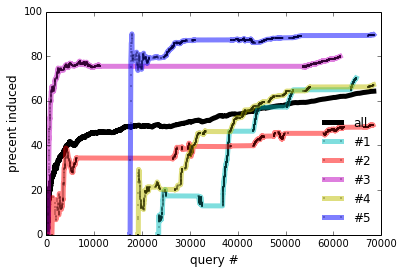

In [10]:
def precent_status_user(filtered_rows):
    query_counts = [r['queryCount'] for r in filtered_rows]
    is_status = [100 if r['stats.status'] == 'Induced' else 0 for r in filtered_rows]
    plot_cumavg(query_counts, is_status, xlabel='query #', ylabel='precent induced');



rows_to_count = [r for r in rows if r['stats.type'] == 'accept']
ranked_users = sorted(reduce(top_users, rows_to_count[5000:], {}).items(), key=lambda x: -x[1])

plt.figure()
topnum = 5;
plot_reset()
p['alpha'] = 1;
p['linewidth'] = 5;
p['label'] = 'all'; 
p['color'] = 'k';
precent_status_user([r for r in rows if r['stats.type'] == 'accept']);    

colors = ['c', 'r', 'm', 'y', 'b', 'g']
plot_reset()
p['alpha'] = 1;
p['linewidth'] = 5;
p['alpha'] = 0.5;
p['marker'] = 'o';
p['markersize'] = 1;

for g in enumerate(ranked_users[0:5]):
    # (0, (u'AMT_A1HKYY6XI2OHO1', 2830))
    p['label'] = '#%d' % (g[0]+1);
    #plotsetting['alpha'] = 1-float(g[0])/topnum;
    p['color'] = colors[g[0]];
    # print plotsetting['color']
    precent_status_user([r for r in rows if r['stats.type'] == 'accept' and r['sessionId'] == g[1][0]])
    print g

plt.ylim(-0.1, 100)
plt.legend(frameon=False, loc='lower right')
savefig('parse_status_topuser.pdf');

avg(formula length): 9.473848
avg(formula length): 90.115215


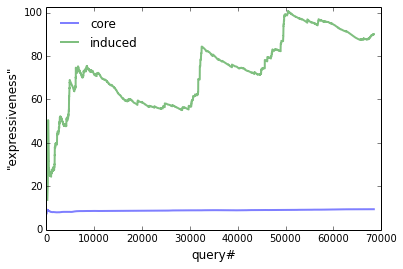

In [15]:
def expressivity(status = 'Core'):
    filtered_rows = [r for r in rows if r['stats.type'] == 'accept' and r['stats.status'] == status]
    query_counts = [r['queryCount'] for r in filtered_rows]
    len_formula = [r['stats.len_formula'] for r in filtered_rows]
    len_utterance = [r['stats.len_utterance'] for r in filtered_rows]
    form_per_q = [float(ls[0])/ls[1] for ls in zip(len_formula, len_utterance)]
    plot_cumavg(query_counts, form_per_q, xlabel='query#', ylabel='"expressiveness"');

    #plot_cumavg(query_counts, len_utterance, xlabel='query#', ylabel='length');
    print_avg(form_per_q, 'formula length')
plt.figure()
plot_reset()
p['color'] = 'b'; p['label'] = 'core'; expressivity('Core')
p['color'] = 'g'; p['label'] = 'induced'; expressivity('Induced')
plt.legend(frameon=False, loc='upper left')
# savefig('expressiveness.pdf')


(0, (u'MT_A3W6T1WDYXMR3', 2596))
(1, (u'MT_A2C7TMRC2QHTIW', 2242))
(2, (u'MT_A2VRDE2FHCBMF8', 1741))
(3, (u'MT_A7HDYVFP9N2Z1', 1419))
(4, (u'MT_A03922113RU44GENR8ATX', 1419))


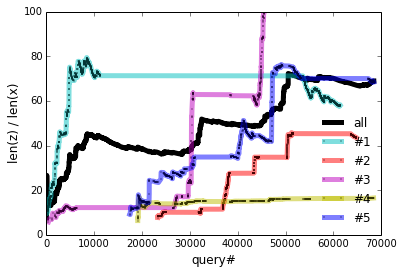

In [14]:
def expressivity_by_users(filtered_rows):
    query_counts = [r['queryCount'] for r in filtered_rows]
    len_formula = [r['stats.len_formula'] for r in filtered_rows]
    len_utterance = [r['stats.len_utterance'] for r in filtered_rows]
    form_per_q = [float(ls[0])/ls[1] for ls in zip(len_formula, len_utterance)]
    plot_cumavg(query_counts, form_per_q, xlabel='query#', ylabel='len(z) / len(x)');

plot_reset()
plt.figure()
p['alpha'] = 1;
p['linewidth'] = 5;
p['label'] = 'all'; 
p['color'] = 'k';
expressivity_by_users([r for r in rows if r['stats.type'] == 'accept' ])
    
colors = ['c', 'r', 'm', 'y', 'b']
plot_reset()
p['alpha'] = 1;
p['linewidth'] = 5;
p['alpha'] = 0.5;
p['marker'] = 'o';
p['markersize'] = 1;
rows_to_count = [r for r in rows if r['stats.type'] == 'accept']
ranked_users = sorted(reduce(top_users, rows_to_count, {}).items(), key=lambda x: -x[1])
for g in enumerate(ranked_users[0:5]):
    print g
    p['label'] = '#%d' % (g[0]+1);
    p['color'] = colors[g[0]];
    expressivity_by_users([r for r in rows if r['stats.type'] == 'accept' \
                     and r['sessionId'] == g[1][0]])

plt.ylim([0,100])
plt.legend(frameon=False, loc='lower right')
savefig('expressiveness_by_user.pdf')